In [1]:
import pandas as pd
import os
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# import nomkl

In [2]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

In [3]:
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')

In [4]:
df.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination
0,1.000000,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,3,3,1,1,1.000000,en-es
1,1.000000,1362082044,5963,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,8,6,6,6,0.750000,en-de
2,0.750000,1362082044,5963,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,6,5,4,3,0.833333,en-de
3,0.888889,1362082044,5963,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,6,5,9,8,0.833333,en-de
4,0.800000,1362082044,5963,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,8,6,5,4,0.750000,en-de


In [5]:
df_1 = df.merge(df_words, on = 'lexeme_id', how='inner')
df_2 = df_1.merge(df_users, on = ['user_id', 'lang_combination'], how='inner')

In [6]:
df_2.columns

Index(['p_recall', 'timestamp', 'delta', 'user_id', 'learning_language',
       'ui_language', 'lexeme_id', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'h_recall', 'lang_combination',
       'gender', 'def', 'tense', 'POS', 'person', 'number', 'word', 'word_len',
       'tags_list', 'SUBTLEX', 'avg_user_p_recall', 'avg_delta', 'std_delta',
       'avg_h_recall'],
      dtype='object')

In [7]:
### PREPARE DATA FOR ML 
dff = df_2.drop(columns=['timestamp', 'lexeme_id', 'word', 'user_id', 'session_seen', 'session_correct'])

In [8]:
dff.columns

Index(['p_recall', 'delta', 'learning_language', 'ui_language', 'history_seen',
       'history_correct', 'h_recall', 'lang_combination', 'gender', 'def',
       'tense', 'POS', 'person', 'number', 'word_len', 'tags_list', 'SUBTLEX',
       'avg_user_p_recall', 'avg_delta', 'std_delta', 'avg_h_recall'],
      dtype='object')

In [9]:
categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()

In [10]:
# Two approaches to handle tags 
# 1) Store tags as list, but delete rows where there are less than x occurences 
dff_1 = dff.copy()
tag_counts = dff_1['tags_list'].value_counts()
rare_threshold = 1000
dff_1['tags_list'] = dff_1['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

dff_1.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True)
dff_1.dropna(inplace=True)

<Axes: >

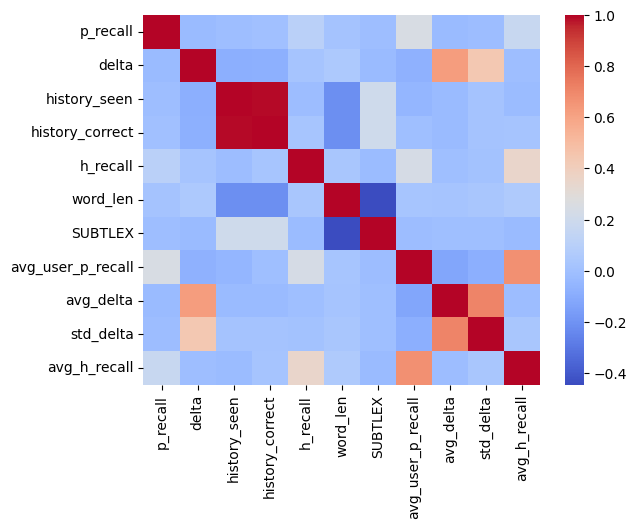

In [11]:
# Correlation between variables
sns.heatmap(dff_1.select_dtypes(exclude='O').corr(), annot=False, cmap='coolwarm')  

In [12]:
# # 2) Store each tag as column, replace NaN values with a placeholder for categorical columns
# dff_2 = dff.copy()
# dff_2[categorical_cols] = dff_2[categorical_cols].fillna('missing')
# dff_2.drop(columns=['tags_list'], inplace=True)

In [13]:
# VIF -> iteratevily delete columns that had VIF > 10
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
    
dff_VIF = dff_1.drop(columns=['p_recall', 'avg_h_recall', 'avg_user_p_recall', 'history_correct'])
# .sample(2000000)
vif = calculate_vif(dff_VIF.select_dtypes(exclude='O'))
vif

,Feature,VIF
0,delta,1.993316
1,history_seen,1.329620
2,h_recall,8.716604
3,word_len,7.043529
4,SUBTLEX,1.397155
5,avg_delta,4.077284
6,std_delta,3.829887


In [14]:
removed_features = ["avg_h_recall", "avg_user_p_recall", 'history_correct']
correlation_with_target = dff_1[removed_features + ["p_recall"]].corr()["p_recall"]
print(correlation_with_target)

avg_h_recall         0.164711
avg_user_p_recall    0.245439
history_correct      0.000409
p_recall             1.000000
Name: p_recall, dtype: float64


In [15]:
# After deleting VIF
# dff_final = dff_1.drop(columns=['avg_user_p_recall'], errors='ignore').sample(5000000)
dff_final = dff_2.drop(columns=['avg_user_p_recall'], errors='ignore').sample(1000000)

In [16]:
dff_final['delta'] = dff_final['delta']/(60*60*24)

In [17]:
# Transforming skewed variables
dff_final['history_seen'] = np.log1p(dff_final['history_seen'])
dff_final['delta'] = np.log1p(dff_final['delta'])

In [18]:
dff_final['history_correct'] = np.log1p(dff_final['history_correct'])

In [19]:
dff_final['avg_delta'] = dff_final['avg_delta']/(60*60*24)

In [20]:
# Transformation of target variable 

# Logit transformation 
def logit_transform(y, epsilon=1e-10):
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

def inverse_logit_transform(y):
    return 1 / (1 + np.exp(-y))


# Log transformation 
def log_transform(y, epsilon=1e-10):
    return np.log(y + epsilon)

def inverse_log_transform(y):
    return np.exp(y)


# Box-Cox transformation
power_transformer = PowerTransformer(method='box-cox', standardize=False)

def power_transform(y, epsilon=1e-10):
    return power_transformer.fit_transform(y+epsilon) 

def inverse_power_transform(y, epsilon=1e-10):
    return power_transformer.inverse_transform(y+epsilon) 

In [21]:
# Create df without word features 
dff_t = dff_final.drop(columns=['tags_list', 'word_len', 'SUBTLEX'], errors='ignore')

# DF original 
dff_s = dff_final.drop(columns=['SUBTLEX', 'tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall', 'avg_user_p_recall', 'lang_combination', 'h_recall'], errors='ignore')

# DF without user columns 
dff_u = dff_final.drop(columns=['avg_delta', 'std_delta', 'avg_h_recall', 'avg_user_p_recall', 'h_recall'], errors='ignore')


In [22]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [23]:
def split_dataset(df):
    X = df.drop(columns='p_recall')
    y = df['p_recall']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [24]:
def cap_y(prediction): 
    return np.clip(prediction, 0, 1)

In [25]:
dff_encoded = ohe(dff_final)
dff_t_encoded = ohe(dff_t)
dff_s_encoded = ohe(dff_s)
dff_u_encoded = ohe(dff_u)


X_train, X_test, y_train, y_test = split_dataset(dff_encoded)
X_train_t, X_test_t, y_train_t, y_test_t = split_dataset(dff_t_encoded)
X_train_s, X_test_s, y_train_s, y_test_s = split_dataset(dff_s_encoded)
X_train_u, X_test_u, y_train_u, y_test_u = split_dataset(dff_u_encoded)

In [26]:
def create_pipeline(model_type="linear", alpha=1.0, **kwargs):
    """
    Create a pipeline for regression with optional feature selection.
    
    Returns:
    - Pipeline object
    """
    if model_type == "ridge":
        model = Ridge(alpha=alpha, fit_intercept=True)
    else:
        model = LinearRegression()

    steps = [
        ('scaler', StandardScaler()),
        # ('polynomial_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('model', model)
        # ('model', TransformedTargetRegressor(regressor=model, 
        #                                     func=log_transform,
        #                                     inverse_func=inverse_log_transform))
    ]
    return Pipeline(steps)

In [27]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name="Model"):
    """
    Train and evaluate a pipeline, returning metrics.
    """
    pipeline.fit(X_train, y_train)
    print('X_train fitted')

    # Predict on both train and test
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    print('Target value predicted')
    
    y_train_pred = cap_y(y_train_pred)
    y_test_pred = cap_y(y_test_pred)

    # Calculate metrics 
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print(f"{name}: Train R2 = {round(train_r2, 4)}, Test R2 = {round(test_r2,4)}, Test MAE = {round(test_mae,4)}")
    return y_train_pred, y_test_pred, test_mae, test_r2

In [28]:
# Define Configurations for Pipelines
pipelines_config = [
    {"name": "Linear Regression", "model_type": "linear"},
    {"name": "Ridge Regression", "model_type": "ridge", "alpha": 100},
    {"name": "Lasso Regression", "model_type": "lasso"},
]


def regression_results(pipelines_config, X_train, X_test, y_train, y_test, importance='No'):
    results = []
    importances = []

    
    for config in pipelines_config:
        pipeline = create_pipeline(**config)
        print('Pipeline created')

        
        y_test_pred, y_train_pred, mae, r2 = evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name=config["name"])
        results.append((config["name"], mae, r2))

        if isinstance(importance, str) and importance == 'Yes':
            model = pipeline.named_steps["model"]
            if isinstance(model, TransformedTargetRegressor):
                regressor = model.regressor
            else:
                regressor = model
            importance = regressor.coef_
            importances.append((config["name"], X_train.columns, importance))

    importance_df = pd.DataFrame(importances, columns = ['Model', 'Feature', 'Importance'])
    results_df = pd.DataFrame(results, columns=['Model', 'Test MAE', 'Test R2'])
    print('Results created')
   
    return results_df, importance_df


In [29]:
print('Results for all features')
results_all = regression_results(pipelines_config, X_train, X_test, y_train, y_test, importance='No')

print('Results after deleting word features')
results_without_word = regression_results(pipelines_config, X_train_t, X_test_t, y_train_t, y_test_t, importance='No')

print('Results without word and user features')
results_original = regression_results(pipelines_config, X_train_s, X_test_s, y_train_s, y_test_s, importance='No')

print('Results without user features') 
results_without_user = regression_results(pipelines_config, X_train_u, X_test_u, y_train_u, y_test_u, importance='No')

Results for all features
Pipeline created
X_train fitted
Target value predicted
Linear Regression: Train R2 = 0.0402, Test R2 = 0.0335, Test MAE = 0.169
Pipeline created
X_train fitted
Target value predicted
Ridge Regression: Train R2 = 0.0394, Test R2 = 0.0319, Test MAE = 0.1693
Pipeline created
X_train fitted
Target value predicted
Lasso Regression: Train R2 = 0.0402, Test R2 = 0.0335, Test MAE = 0.169
Results created
Results after deleting word features
Pipeline created
X_train fitted
Target value predicted
Linear Regression: Train R2 = 0.0402, Test R2 = 0.0335, Test MAE = 0.1691
Pipeline created
X_train fitted
Target value predicted
Ridge Regression: Train R2 = 0.0393, Test R2 = 0.032, Test MAE = 0.1693
Pipeline created
X_train fitted
Target value predicted
Lasso Regression: Train R2 = 0.0402, Test R2 = 0.0335, Test MAE = 0.1691
Results created
Results without word and user features
Pipeline created
X_train fitted
Target value predicted
Linear Regression: Train R2 = 0.015, Test R2 

In [30]:
# Test MSE Plot
plt.subplot(1, 2, 1)
plt.bar(results_all['Model'], results_all['Test MSE'], color='skyblue')
plt.title('Test MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)


# # Test R2 Plot
# plt.subplot(1, 2,1)
# plt.bar(results_all['Model'], results_all['Test R2'], color='lightgreen')
# plt.title('Test R2 Comparison')
# plt.ylabel('R2 Score')
# plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Check if residuals are normally distributed 
sns.distplot((y_test-y_pred_capped),bins=50);

# 